# **Basic Well Log Interpretation - Final Project**
Initial code from https://github.com/petroGG/Basic-Well-Log-Interpretation/tree/master<br>

# **0. Import Python Library**

In [1]:
# Plotting and Data Manipulation
from decimal import DivisionByZero
import pandas as pd
import numpy as np
import math

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

import lasio

# **1. Read LAS data and Change the Format into Dataframe**

### **1.1 Column name adjustments for each well** <br>
Do a rename for columns that don't match the sourcecode. For data columns that are intended to be plotted, they must match as follows:
- **DEPT**
- **Traject 1: GR, CALI, SP**
- **Traject 2: DR, MR, SR**
- **Traject 3: RHOB, NPHI, DT**

In [2]:
def read_las(
    file_name, well_name, columns_to_rename, columns_to_keep, keep_original=False
):
    file_name = file_name
    data = lasio.read(file_name).df().reset_index()

    data = data.rename(columns=columns_to_rename)
    data = data.filter(columns_to_keep)

    # Insert Well name columns in the first col index
    data.insert(0, "WELL", well_name)

    if keep_original:
        data.fillna(-999.25, inplace=True)

    return data

In [3]:
file_name = "../data/raw/lld-18_wire_lima.las"
well_name = "LLD-18"
renamed_columns = {
    "DEPTH": "DEPT",
    "RT": "DR",
    "ILM": "MR",
    "LLS": "SR",
    "NPHI_CORR": "NPHI",
}  # {nama_asli : nama_baru, ... , dst}
columns = ["DEPT", "GR", "CALI", "MR", "DR", "SR", "NPHI", "RHOB", "VSH", "RW", "WELL"]

data = read_las(file_name, well_name, renamed_columns, columns, keep_original=False)

Only engine='normal' can read wrapped files


In [4]:
data.describe()

,DEPT,GR,DR,SR,NPHI,RHOB,VSH,RW
count,10133.000000,9291.000000,9271.000000,9271.000000,2478.000000,2501.000000,6034.000000,10133.000000
mean,2533.000000,66.550534,1.636807,1.017569,0.469376,2.208437,0.549701,0.131896
std,1462.644736,19.689320,10.749416,2.245749,0.073722,0.117789,0.333390,0.029389
min,0.000000,10.732400,0.100000,0.100000,0.131300,1.462000,0.000000,0.094080
25%,1266.500000,53.827400,0.761000,0.672200,0.429000,2.178000,0.205700,0.107490
50%,2533.000000,72.621100,0.863400,0.792200,0.469800,2.231200,0.650950,0.125110
75%,3799.500000,80.739800,1.112650,1.023750,0.505900,2.270100,0.835000,0.149840
max,5066.000000,108.563800,200.000000,200.000000,0.864600,2.687000,1.000000,0.207730


# **2. Functions for Data Distribution Plots**

### ***2.1. Data distribution based on Histogram Plot***

In [5]:
def histplot(
    data,
    columns_to_plot,
    columns_unit,
    depth_start=data.DEPT.min(),
    depth_end=data.DEPT.max(),
    axes=(3, 3),
    fig_size=(12, 12),
):
    # Get unique wells and assign colors
    wells = data["WELL"].unique()
    colors = sns.color_palette("viridis", n_colors=len(wells))

    # Create subplots for histograms
    fig, axes = plt.subplots(axes[0], axes[1], figsize=fig_size)
    fig.suptitle(
        f"DATA DISTRIBUTION (HISTOGRAM PLOT) from {depth_start}ft to {depth_end}ft \n",
        fontsize=14,
        fontweight="bold",
    )
    fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)

    # List of columns and their corresponding units
    columns = columns_to_plot
    units = columns_unit

    for i, ax in enumerate(axes.flat):
        if i < len(columns):
            column_name = columns[i]
            column_unit = units[i]  # Specify the unit for the column
            ax.set_title(column_name)

            # Plot histograms for each well with different colors
            for well, color in zip(wells, colors):
                well_data = data[
                    (data["WELL"] == well)
                    & (data["DEPT"] >= depth_start)
                    & (data["DEPT"] <= depth_end)
                ]
                sns.histplot(
                    well_data[column_name].dropna(),
                    bins=50,
                    color=color,
                    ax=ax,
                    kde=True,
                    label=well,
                )

            ax.set_xlabel(
                f"{column_name} [{column_unit}]"
            )  # Include the specified unit in the x-axis label
            ax.legend(title="WELL")

    # Remove empty subplots if there are more plots than columns
    if len(columns) < len(axes.flat):
        for i in range(len(columns), len(axes.flat)):
            fig.delaxes(axes.flat[i])

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

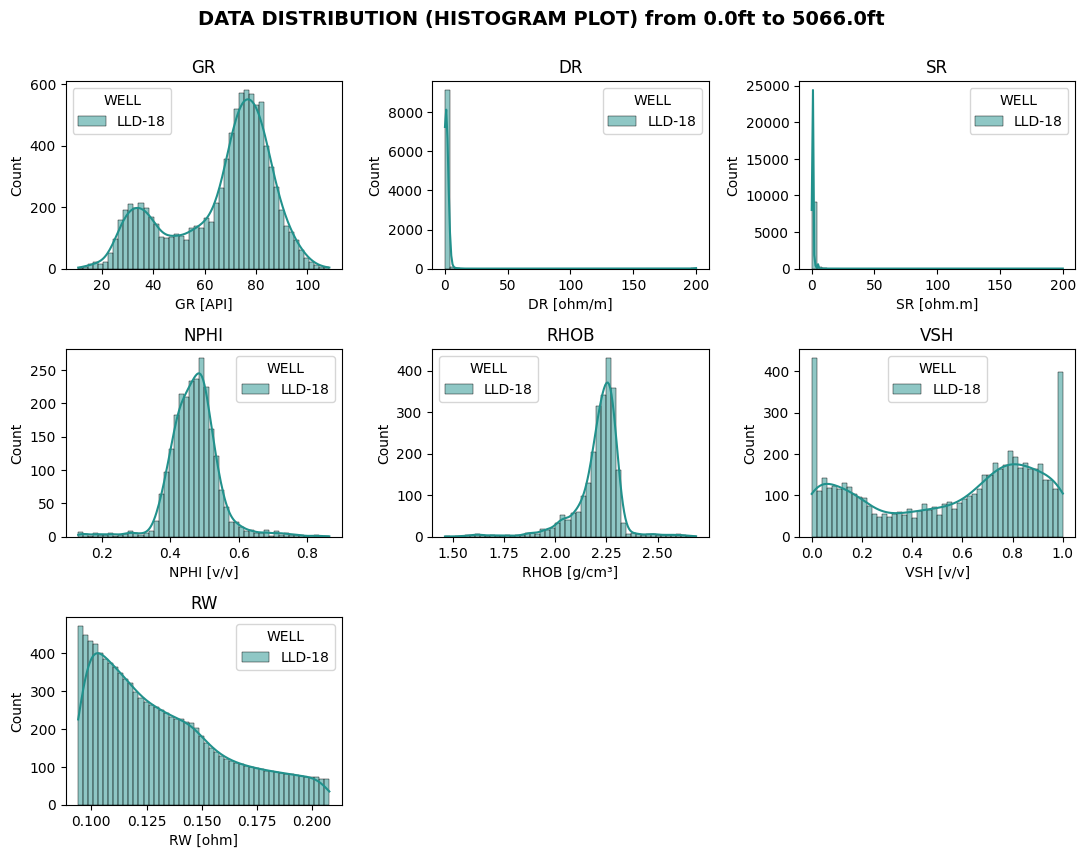

In [6]:
columns_to_plot = ["GR", "DR", "SR", "NPHI", "RHOB", "VSH", "RW"]
columns_unit = ["API", "ohm/m", "ohm.m", "v/v", "g/cm³", "v/v", "ohm"]

histplot(data, columns_to_plot, columns_unit, axes=(4, 3), fig_size=(11, 11))

# **3. Input Core Data (Porosity and Permeability) for Selected Well**
this code block is still **experimental**, make sure you know what you're doing if u want to change any part of the code

In [7]:
data["core_por"] = ""
data["core_perm"] = ""

# Define the number of random samples you want
num_samples = 100  # You can change this to the desired number of samples

# Generate random values for 'DEPT' between 900 and 4300
dept_values = np.random.uniform(0, 8400, num_samples)

# Generate random values for 'core_por' between 0 and 1 and "core_perm" between 0 and 1000
core_por_values = np.random.uniform(0, 1, num_samples)
core_perm_values = np.random.uniform(0, 1000, num_samples)

# Create a dictionary with the generated values. This for example only
dict_core = {
    "DEPT": dept_values.tolist(),  # Convert to a list
    "core_por": core_por_values.tolist(),  # Convert to a list
    "core_perm": core_perm_values.tolist(),  # Convert to a list
}

# must inpute manually based on core data
"""dict_core = {'DEPT':[4220,4240,4260],
        'DEPT':[4220,4240,4260],
        'core_por':[0.148, 0.287,0.103],
        'core_perm':[0.0001,0.0001,0.0001]
       } """


core_selected_data = pd.DataFrame(dict_core)
data.set_index("DEPT")

,WELL,GR,DR,SR,NPHI,RHOB,VSH,RW,core_por,core_perm
DEPT,,,,,,,,,,
0.0,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.20773,,
0.5,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.20770,,
1.0,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.20766,,
1.5,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.20763,,
2.0,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.20760,,
...,...,...,...,...,...,...,...,...,...,...
5064.0,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.09410,,
5064.5,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.09410,,
5065.0,LLD-18,NaN,NaN,NaN,NaN,NaN,NaN,0.09409,,


# **4. DISPLAY DATA LOGS**
Display is done by describing a function named combo_plot<br>
combo_plot displays three traject, namely:<br>
- **Traject 1: GR, SP, CALI**
- **Traject 2: Resistivities (ILD, ILM, ILS, LL8, SFL, or other)**
- **Traject 3: Density (RHOB), Sonic(DT) and Neutronic (NPHI)**

In [8]:
# helper Function for Combo plot Procedure
def add_trajectory(ax, data, traject, use_xticks=False):
    for i in range(len(traject["data"])):
        twin_ax = ax.twiny()
        if use_xticks:
            twin_ax.set_xticks(
                range(
                    traject["intervals"][i][0],
                    traject["intervals"][i][1],
                    traject["intervals"][i][2],
                )
            )
        else:
            twin_ax.set_xlim(traject["intervals"][i])
        twin_ax.set_xscale(traject["scales"][i])
        twin_ax.set_xlabel(traject["labels"][i], color=traject["colors"][i])
        if "positions" in traject:
            twin_ax.spines["top"].set_position(("outward", traject["positions"][i]))
        twin_ax.plot(
            data[traject["data"][i]],
            data.DEPT,
            label=traject["labels"][i],
            color=traject["colors"][i],
        )
        if "positions" in traject:
            twin_ax.tick_params(axis="x", colors=traject["colors"][i])


# Create the figure and subplots
def combo_plot(
    data,
    top_depth: float,
    bottom_depth: float,
    figure_height: float,
    suptitleadjust: float,
    traject1: dict,
    traject2: dict,
    traject3: dict,
    ticks_interval="auto",
):

    selected_data = data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(
        nrows=1, ncols=3, figsize=(12, figure_height), sharey=True
    )  # pembuatan format 1 baris 3 kolom, width 12 height 10, dan sumbu y yang sama (sharey)
    fig.suptitle(
        f"WELL COMPOSITE {top_depth}ft to {bottom_depth}ft".upper(),
        y=suptitleadjust,
        va="bottom",
    )
    fig.subplots_adjust(wspace=0.1)

    # General setting for all axis
    for axes in ax:
        axes.set_ylim(top_depth, bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.yaxis.grid(True, which="minor", linestyle=":")
        axes.yaxis.grid(True, which="major", linestyle="-", linewidth="1")
        for i, j in zip(formation_depths, formations):
            if (i >= top_depth) and (i <= bottom_depth):
                axes.axhline(y=i, linewidth=0.5, color="black")
                axes.text(
                    0.1, i, j, horizontalalignment="center", verticalalignment="center"
                )

        if ticks_interval == "auto":
            axes.yaxis.set_major_locator(ticker.AutoLocator())
            axes.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        else:
            axes.yaxis.set_major_locator(ticker.MultipleLocator(ticks_interval[0]))
            axes.yaxis.set_minor_locator(ticker.MultipleLocator(ticks_interval[1]))

        axes.get_xaxis().set_visible(False)

    # 1st Trajectory: typically for GR, CALI, SP
    add_trajectory(ax[0], selected_data, traject1)

    # 2nd Trajectory: typically for Resistivity
    if traject2:
        add_trajectory(ax[1], selected_data, traject2)

    # 3rd Trajectory: typically for NPHI, RHOB, etc
    if traject3:
        add_trajectory(ax[2], selected_data, traject3)

    plt.show()

### **4.1 Define Formation**
this where you put your well formation structure, the plot will automatically create an horizontal line to anotate the formation in the corresponding depth
Note to new users:
1. **Make sure the number of elements in formation and formation_depths are equal**
2. **The formation depth should'nt exceed max depth in your data**
3. **Put the formation list and formation depths in sequential order**

In [9]:
formations = (
    "Torok",
    "Pebble SH",
    "Walakpa SS",
    "J-Klingak",
    "Barrow SS",
    "Klingak SH",
    "T-Sag River SS",
    "Shublik",
    "Basement",
)
formation_depths = (100, 1701, 2071, 2200, 3102, 3224, 3258, 3633)

### **4.2 Adjust NPHI with correction factor -> convert sandstone to limestone scale or otherwise**

In [10]:
data["NPHI_corr"] = data["NPHI"] - 0.04

data[["NPHI", "NPHI_corr"]][(data.DEPT > 4000) & (data.DEPT < 5000)]

,NPHI,NPHI_corr
8001,0.4278,0.3878
8002,0.4517,0.4117
8003,0.4530,0.4130
8004,0.4733,0.4333
8005,0.4412,0.4012
...,...,...
9995,NaN,NaN
9996,NaN,NaN
9997,NaN,NaN
9998,NaN,NaN


### **4.2. Full depth display**

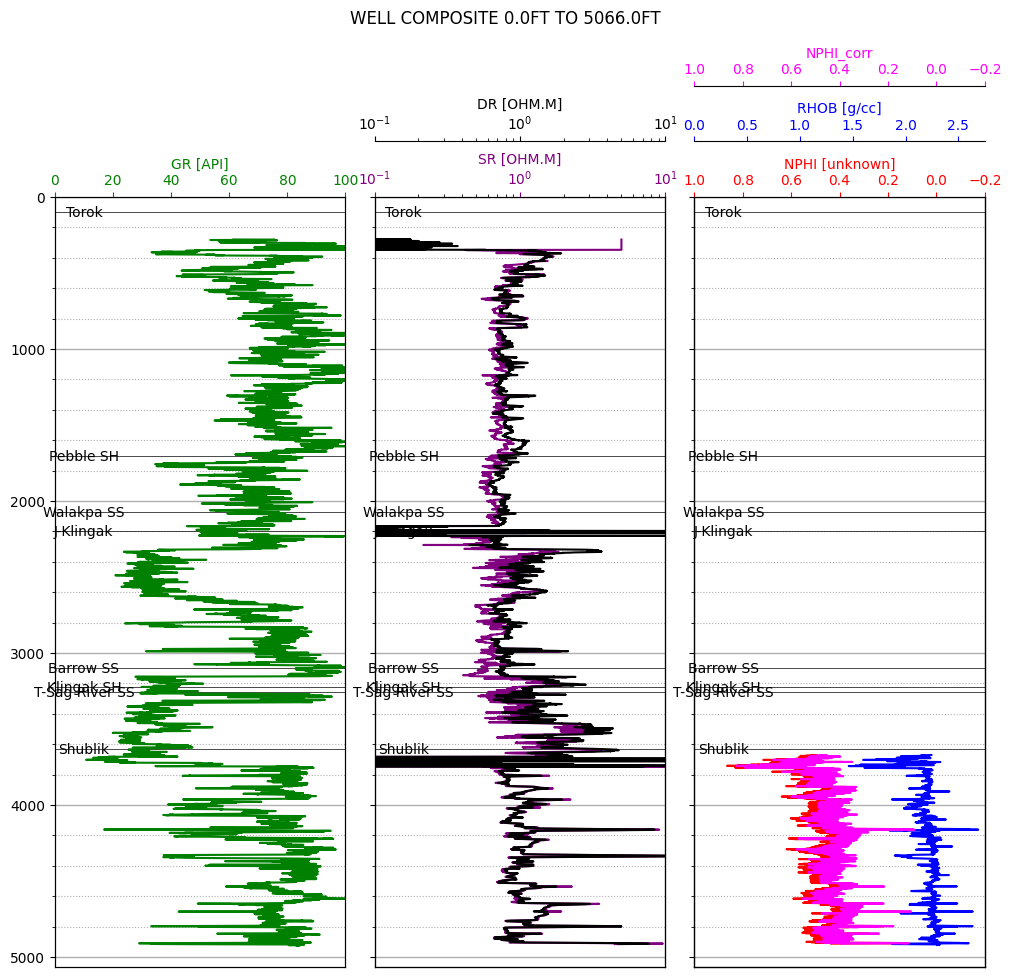

In [11]:
# DISPLAYS LOG DATA FROM THE TOP TO THE BOTTOM (raw)
# run the combo_plot
combo_plot(
    data,
    data.DEPT.min(),
    data.DEPT.max(),
    10,  # figure height in inch
    1.05,  # title position
    traject1={
        "data": ["GR"],
        "intervals": [(0, 100)],
        "scales": ["linear"],
        "labels": ["GR [API]"],
        "positions": [0],
        "colors": ["green"],
    },
    traject2={
        "data": ["SR", "DR"],
        "intervals": [(0.1, 10), (0.1, 10)],
        "scales": ["log", "log"],
        "labels": ["SR [OHM.M]", "DR [OHM.M]"],
        "positions": [0, 40],
        "colors": ["purple", "black"],
    },
    traject3={
        "data": ["NPHI", "RHOB", "NPHI_corr"],
        "intervals": [(1.0, -0.2), (0, 2.75), (1.0, -0.2)],
        "scales": ["linear", "linear", "linear"],
        "labels": ["NPHI [unknown]", "RHOB [g/cc]", "NPHI_corr"],
        "positions": [0, 40, 80],
        "colors": ["red", "blue", "magenta"],
    },
)

### **4.3. Selected Depth Display**

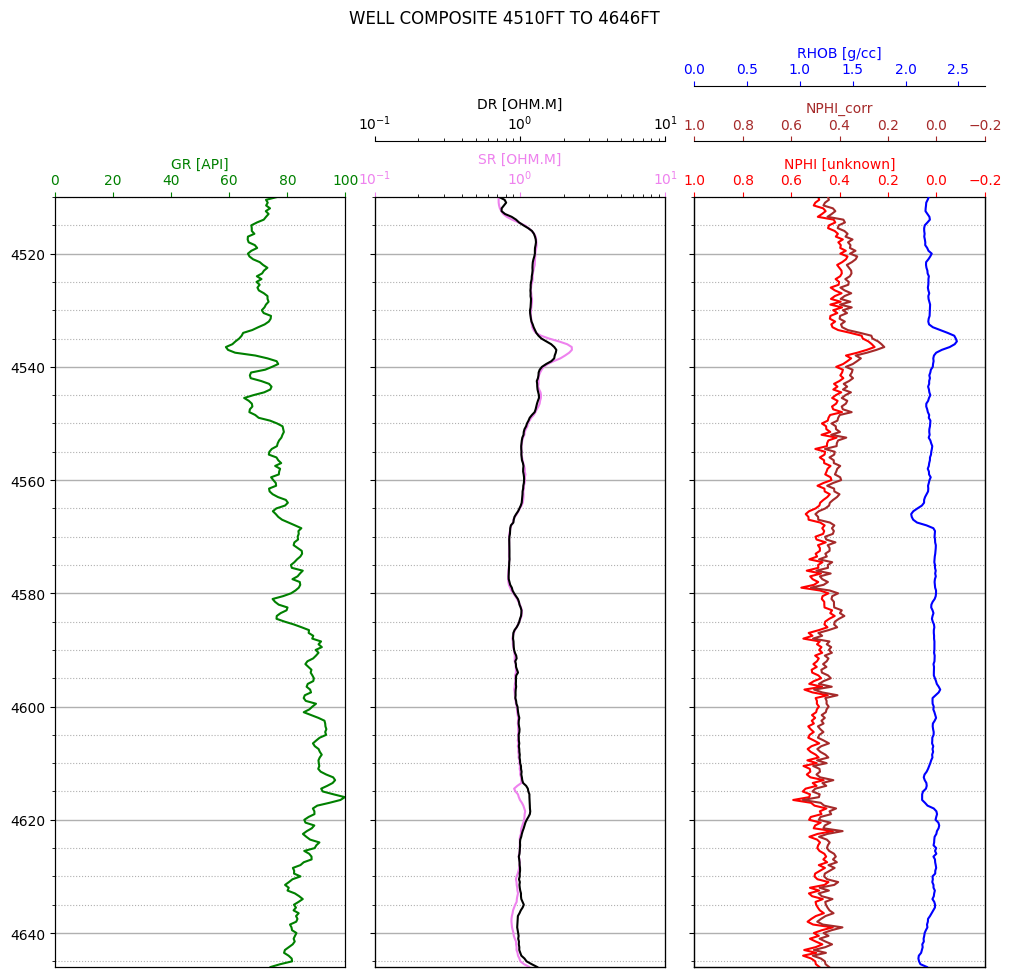

In [12]:
# MENAMPILKAN DATA LOG DARI UJUNG ATAS SAMPAI BAWAH YANG DIINGINKAN
depth_start = 4510
depth_end = 4646

combo_plot(
    data,
    depth_start,
    depth_end,
    10,  # figure height in inch
    1.05,  # title position
    traject1={
        "data": ["GR"],
        "intervals": [(0, 100)],
        "scales": ["linear"],
        "labels": ["GR [API]"],
        "positions": [0],
        "colors": ["green"],
    },
    traject2={
        "data": ["SR", "DR"],
        "intervals": [(0.1, 10), (0.1, 10)],
        "scales": ["log", "log"],
        "labels": ["SR [OHM.M]", "DR [OHM.M]"],
        "positions": [0, 40],
        "colors": ["violet", "black"],
    },
    traject3={
        "data": ["NPHI", "NPHI_corr", "RHOB"],
        "intervals": [(1.0, -0.2), (1.0, -0.2), (0, 2.75)],
        "scales": ["linear", "linear", "linear"],
        "labels": ["NPHI [unknown]", "NPHI_corr", "RHOB [g/cc]"],
        "positions": [0, 40, 80],
        "colors": ["red", "brown", "blue"],
    },
    ticks_interval=[20, 5],
)

### **4.4. Custom Variable Display**

In [13]:
def custom_interpretation_plot(data, depth_start, depth_end, custom_data, units):
    selected_data = data[(data.DEPT >= depth_start) & (data.DEPT <= depth_end)]
    num_tracks = len(custom_data)
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(15, 10), sharey=True)
    fig.suptitle("Custom Interpretation Plot", fontsize=22)

    # Calculate top value with less free space based on the number of tracks
    top_value = 1 - 0.015 * 7

    # Adjust top parameter to leave less free space at the top
    fig.subplots_adjust(top=top_value, wspace=0.2)

    units = units  # in list

    # General setting for all axes
    for axes in ax:
        axes.set_ylim(depth_start, depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which="minor", linestyle=":")
        axes.yaxis.grid(True, which="major", linestyle="-", linewidth="1")
        axes.yaxis.set_major_locator(ticker.AutoLocator())
        axes.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        axes.get_xaxis().set_visible(False)

    # Customizing each track with unit and color
    for i, data_name in enumerate(custom_data):
        current_ax = ax[i].twiny()
        current_ax.plot(
            selected_data[data_name],
            selected_data.DEPT,
            label=f"{data_name} [{units[i]}]",
            color="C" + str(i),
        )
        if data_name == "DR" or data_name == "MR" or data_name == "SR":
            current_ax.set_xlim(0.1, 10)
            current_ax.set_xscale("log")
        elif data_name == "RW":
            current_ax.set_xlim(0.01, 1)
            current_ax.set_xscale("log")
        current_ax.set_xlabel(f"{data_name} [{units[i]}]", color="C" + str(i))
        current_ax.tick_params(axis="x", colors="C" + str(i))
        current_ax.spines["top"].set_position(("outward", 0))
        current_ax.legend(
            loc="lower right", facecolor="white", framealpha=1, fontsize=7
        )
    plt.show()

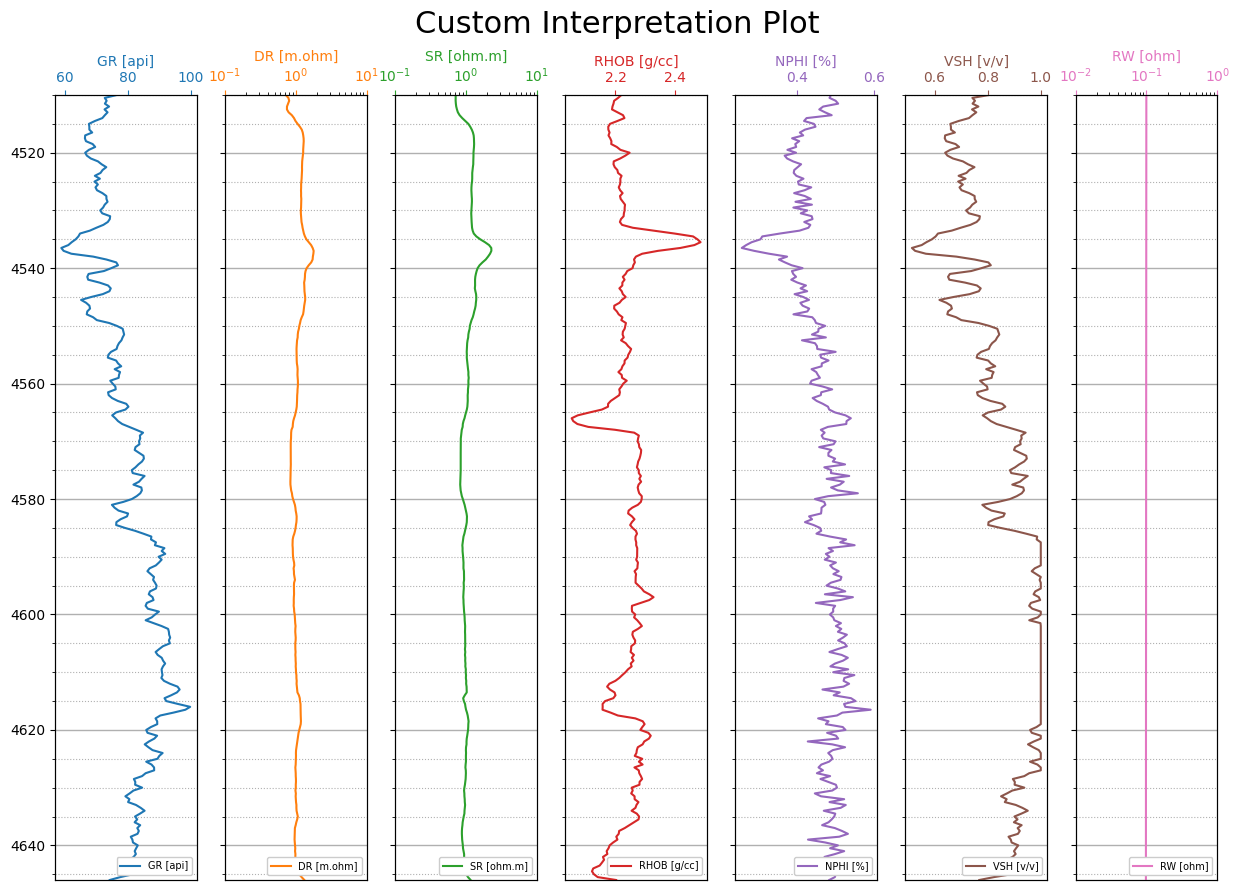

In [14]:
custom_logs = ["GR", "DR", "SR", "RHOB", "NPHI", "VSH", "RW"]
units = ["api", "m.ohm", "ohm.m", "g/cc", "%", "v/v", "ohm"]

custom_interpretation_plot(data, depth_start, depth_end, custom_logs, units)

# **5. CLAY VOLUME CALCULATION**

### **5.1. Single Method with Gamma Ray Log**
#### **The calculation of the volume of clay is carried out using five equation options, namely:**
**Linear Gamma Ray Equation:**
- *Formula:* $ VCL_{gr}=I_{gr} = \frac{gr_{log}-gr_{clean}}{gr_{clay}-gr_{clean}}$
- *Explanation:* Calculates the Volume of Clay $VCL_{gr}$ based on gamma ray log $gr_{log}$, clean sand gamma ray $gr_{clean}$, and clay gamma ray $gr_{clay}$.
**Larionov (Tertiary/Young Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.083(2^{3.7*I_{gr}}-1)$
- *Explanation:* Specifically designed for tertiary/young rocks, using the gamma ray index $I_{gr}$.
**Larionov (Old Rocks) Equation:**
- *Formula:* $ VCL_{gr} = 0.33(2^{2\times I_{gr}}-1)$
- *Explanation* Tailored for old rocks, also utilizing the gamma ray index $I_{gr}$
**Clavier Equation:**
- *Formula:* $ VCL_{gr} = 1.7 - (3.38-(I_{gr}+0.7)^2)^{\frac{1}{2}} $
- *Explanation:* Involves a square root term and is based on the gamma ray index $I_{gr}$.
**Steiber Equation:**
- *Formula:* $ VCL_{gr} = 0.5(\frac{I_{gr}}{1.5-I_{gr}})$
- *Explanation:* Includes a ratio of the gamma ray index $I_{gr}$.

In [15]:
def vclgr(gr_log, gr_clean, gr_clay, correction=None):

    igr = (gr_log - gr_clean) / (gr_clay - gr_clean)

    if correction == "young":
        vclgr = 0.083 * (2 ** (3.7 * igr) - 1)

    elif correction == "older":
        vclgr = 0.33 * (2 ** (2 * igr) - 1)

    elif correction == "clavier":
        vclgr = 1.7 - (3.38 - (igr + 0.7) ** 2) ** 0.5

    elif correction == "steiber":
        vclgr = 0.5 * igr / (1.5 - igr)

    else:
        vclgr = igr

    return vclgr

### **5.2. Single Method with Spontaneous Potential Log:**
The volume of clay $VCL_{sp}$ can be determined using the Spontaneous Potential (SP) log with the following equation:
$$VCL_{sp} = \frac{sp_{log} - sp_{clean}}{sp_{clay} - sp_{clean}}$$
- **Formula Explanation:**
  - $VCL_{sp}$: Volume of Clay using Spontaneous Potential.
  - $sp_{log}$: Spontaneous Potential log value.
  - $sp_{clean}$: SP value in clean formations.
  - $sp_{clay}$: SP value in clay-rich formations.
This equation provides a method for estimating the volume of clay based on the SP log measurements, where the SP log is compared to clean and clay values.

In [16]:
def vclsp(sp_log, sp_clean, sp_clay):
    vclsp = (sp_log - sp_clean) / (sp_clay - sp_clean)
    return vclsp

### **5.3. Single Method with Resistivity Log:**
The volume of clay $V_{rt}$ can be calculated using the Resistivity (RT) log with the following equation:
$$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$$
- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.
If $rt_{log} > 2 \times rt_{clay}$, then the volume of clay $VCL_{rt}$ is calculated as follows:
$$VCL_{rt} = 0.5(2 \times V_{rt})^{(0.67(V_{rt} + 1))}$$
- **Condition Explanation:**
  - $rt_{log}$ greater than twice $rt_{clay}$ triggers the second part of the calculation.
This method provides a way to estimate the volume of clay based on the Resistivity log, with a condition for specific scenarios where $rt_{log}$ exceeds a threshold relative to $rt_{clay}$.

In [17]:
def vclrt(rt_log, rt_clean, rt_clay):
    vrt = (rt_clay / rt_log) * (rt_clean - rt_log) / (rt_clean - rt_clay)

    vclrt = np.where(rt_log > 2 * rt_clay, 0.5 * (2 * vrt) ** (0.67 / (vrt + 1)), vrt)

    return vclrt

### **5.4. Dual Method with N-D Crossplot**
Dual methods involve the utilization of neutron-density crossplots, which are based on the correlation between neutron and density measurements. These crossplots depict the identification of a 'clean line' and a 'clay point,' as illustrated in the accompanying graphs.
1. Clean Line: The clean line on the neutron-density crossplot typically represents a linear trend that corresponds to rocks with minimal clay content. Rocks along this line have a consistent ratio of neutron and density measurements. This could correspond to sandstones or other clean, mineral-rich formations.
2. Clay Point: The clay point is a marker on the crossplot that corresponds to clay-rich formations. These formations will exhibit different neutron and density measurements compared to the clean line due to their higher clay content.

The terms **term1** and **term2** are defined as follows:
$$
\text{term1} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{log}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{log}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$
$$
\text{term2} = (\rho_{\text{clean2}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clay}} - \text{neut}_{\text{clean1}}) - (\rho_{\text{clay}} - \rho_{\text{clean1}}) \cdot (\text{neut}_{\text{clean2}} - \text{neut}_{\text{clean1}})
$$
The volume of clay and neutron-density (\(VCL_{nd}\)) is then calculated as:
$$
VCL_{nd} = \frac{\text{term1}}{\text{term2}}
$$
- **Variables Explanation:**
  - $\rho_{\text{clean1}}$, $\rho_{\text{clean2}}$: Density values in clean formations.
  - $\rho_{\text{log}}$: Density log value.
  - $\text{neut}_{\text{clean1}}$, $\text{neut}_{\text{clean2}}$: Neutron-density values in clean formations.
  - $\text{neut}_{\text{log}}$: Neutron-density log value.
  - $\text{neut}_{\text{clay}}$: Neutron-density value in clay-rich formations.
This equation provides a method for calculating the volume of clay and neutron-density based on a neutron-density crossplot with density and neutron-density log measurements and values in clean formations.

In [18]:
def vclnd(
    neut_log,
    den_log,
    neut_clean1,
    den_clean1,
    neut_clean2,
    den_clean2,
    neut_clay,
    den_clay,
):
    term1 = (den_clean2 - den_clean1) * (neut_log - neut_clean1) - (
        den_log - den_clean1
    ) * (neut_clean2 - neut_clean1)
    term2 = (den_clean2 - den_clean1) * (neut_clay - neut_clean1) - (
        den_clay - den_clean1
    ) * (neut_clean2 - neut_clean1)
    vclnd = term1 / term2
    return vclnd

## **Define a Copy DataFrame for Calculations**

In [19]:
calculation_data = data.copy()

In [20]:
calculation_data.describe()

,DEPT,GR,DR,SR,NPHI,RHOB,VSH,RW,NPHI_corr
count,10133.000000,9291.000000,9271.000000,9271.000000,2478.000000,2501.000000,6034.000000,10133.000000,2478.000000
mean,2533.000000,66.550534,1.636807,1.017569,0.469376,2.208437,0.549701,0.131896,0.429376
std,1462.644736,19.689320,10.749416,2.245749,0.073722,0.117789,0.333390,0.029389,0.073722
min,0.000000,10.732400,0.100000,0.100000,0.131300,1.462000,0.000000,0.094080,0.091300
25%,1266.500000,53.827400,0.761000,0.672200,0.429000,2.178000,0.205700,0.107490,0.389000
50%,2533.000000,72.621100,0.863400,0.792200,0.469800,2.231200,0.650950,0.125110,0.429800
75%,3799.500000,80.739800,1.112650,1.023750,0.505900,2.270100,0.835000,0.149840,0.465900
max,5066.000000,108.563800,200.000000,200.000000,0.864600,2.687000,1.000000,0.207730,0.824600


### **5.6. Clay Volume Calculation Function**

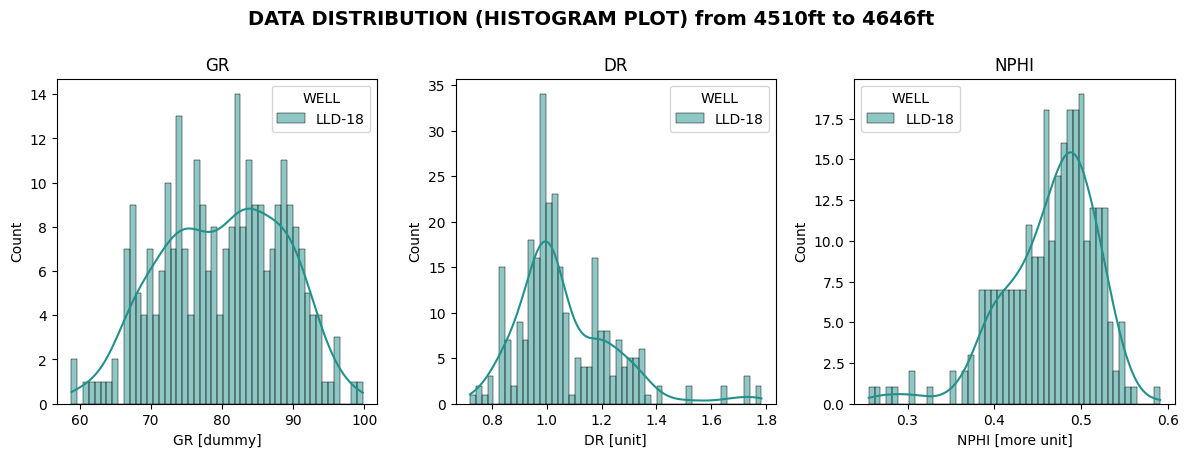

In [21]:
columns_list = ["GR", "DR", "NPHI"]
the_units = ["dummy", "unit", "more unit"]

histplot(calculation_data, columns_list, the_units, depth_start=4510, depth_end=4646)

#### **5.6.1. Define the Clean and Clay Paramater**
- Minimum (clean) and maximum (clay) values of GR for both
- Minimum (clean) and maximum (clay) values of SP for both
- Minimum (clean) and maximum (clay) values of RT for both
To start with, simply guess any numbers. Then, refer to the crossplot results in section 5.5.3

In [22]:
# Clean point 1 (typical for a dense, clean rock like limestone)
neut_clean1 = 0.04
den_clean1 = 2.65

# Clean point 2 (moderate porosity, consolidated formation)
neut_clean2 = 0.38
den_clean2 = 1.9

# Clay point (high density, low porosity)
neut_clay = 0.7
den_clay = 2.2

# sand and shale baseline
gr_clean = 40
gr_clay = 110
rt_clean = 1.8
rt_clay = 0.6

# 5.7 ND - Crossplot to determine the best clean point and clay points

In [23]:
def nd_crossplot(
    data, ax, clean_point1, clean_point2, clay_point, nphi_axis, rhob_axis
):
    if all(curve in data.columns for curve in ["NPHI", "RHOB"]):
        points = ax.scatter(
            data.NPHI_corr,
            data.RHOB,
            c=data.GR if "GR" in data.columns else "blue",
            s=5,
            cmap="viridis",
        )
        cbar = plt.colorbar(points)
        cbar.set_label("GR [API]", rotation=90, size=5)
        ax.set_xlabel("NPHI [%]")
        ax.set_ylabel("RHOB [g/cc]")
        ax.invert_yaxis()
        ax.invert_xaxis()
        ax.grid(True)

        # Add axis limits (set constraints here)
        ax.set_xlim(nphi_axis)  # Example for NPHI, adjust based on your data
        ax.set_ylim(rhob_axis)

        # Plot clean and clay points if provided
        if all(
            clean_point is not None
            for clean_point in [
                clean_point1[0],
                clean_point1[1],
                clean_point2[0],
                clean_point2[1],
            ]
        ):
            ax.plot(
                [clean_point1[0], clean_point2[0]],
                [clean_point1[1], clean_point2[1]],
                marker="o",
                color="black",
                linewidth=1,
            )
            ax.text(
                clean_point1[0],
                clean_point1[1],
                "clean point 1",
                fontsize=6,
                bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8),
            )
            ax.text(
                clean_point2[0],
                clean_point2[1],
                "clean point 2",
                fontsize=6,
                bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8),
            )

        if clay_point[0] is not None and clay_point[1] is not None:
            ax.plot(clay_point[0], clay_point[1], marker="o", color="red", linewidth=1)
            ax.text(
                clay_point[0],
                clay_point[1],
                "clay point",
                fontsize=6,
                bbox=dict(boxstyle="round", fc="white", ec="0.5", alpha=0.8),
            )

#### **5.7.1. Do the Clay Volume Calculation**

In [24]:
calculation_data["VCLGR"] = vclgr(data.GR, gr_clean, gr_clay, correction="older")
calculation_data["VCLRT"] = vclrt(data.DR, rt_clean, rt_clay)
calculation_data["VCLND"] = vclnd(
    data.NPHI_corr,
    data.RHOB,
    neut_clean1,
    den_clean1,
    neut_clean2,
    den_clean2,
    neut_clay,
    den_clay,
)

In [25]:
calculation_data[["DEPT", "VCLND", "VCLRT", "VCLGR"]][
    (calculation_data.DEPT >= depth_start) & (calculation_data.DEPT <= depth_end)
]

,DEPT,VCLND,VCLRT,VCLGR
9020,4510.0,0.465977,0.748266,0.349603
9021,4510.5,0.447444,0.645767,0.300072
9022,4511.0,0.469111,0.618012,0.307539
9023,4511.5,0.481278,0.658749,0.300622
9024,4512.0,0.392371,0.700801,0.317403
...,...,...,...,...
9288,4644.0,0.510287,0.378820,0.404890
9289,4644.5,0.432845,0.336353,0.420515
9290,4645.0,0.402485,0.309134,0.422789
9291,4645.5,0.409728,0.341631,0.364554


### **6.5. Display for Traject and Histogram (GR and SP), N-D Crossplot, and VCL**
Several displays will be generated, including GR, SP vs. DEPTH track, histograms, neutron-density crossplot, and VCL track. These displays serve the purpose of observing and selecting the suitable parameters for distinguishing between clay-rich and clean formations. Additionally, they will allow for a comparison of the outcomes obtained from the various VCL calculation methods mentioned previously.
#### **6.5.1. VCL Plot Function** <br>

In [26]:
def vcl_plot(
    data,
    depth_start,
    depth_end,
    traject1: dict,
    traject2: dict,
    traject3: dict,
    clean_point1=[neut_clean1, den_clean1],
    clean_point2=[neut_clean2, den_clean2],
    clay_point=[neut_clay, den_clay],
    rhob_axis=[1.5, 2.8],
    nphi_axis=[0, 1],
):
    """
    Plot volume of clay from different methods with handling for missing data

    Parameters:
    -----------
    logs : pandas DataFrame
        Well log data containing depth and measurement curves
    depth_start, depth_end : float
        Depth range for plotting
    *_clean, *_clay : float, optional
        Clean and clay points for different methods
    """
    # filter the well depths:
    well_data = data[(data["DEPT"] >= depth_start) & (data["DEPT"] <= depth_end)]

    # Create figure and gridspec
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle("Volume of clay from different methods", fontsize=14)
    fig.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)

    gs = gridspec.GridSpec(3, 3)

    # Initialize subplots
    ax1 = fig.add_subplot(gs[:, 0])  # All rows, column 1
    ax2 = fig.add_subplot(gs[0, 1])  # Row 1, column 2a
    ax3 = fig.add_subplot(gs[1, 1])  # Row 2, column 2b
    ax4 = fig.add_subplot(gs[2, 1])  # Row 3, column 2c
    ax5 = fig.add_subplot(gs[:, 2])  # Row all rows, column 3

    # Plot GR and SP (if available)
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_ylim(depth_start, depth_end)
    ax1.set_ylabel("DEPTH")
    for i in range(len(traject1["data"])):
        ax1.plot(
            well_data[traject1["data"][i]], well_data.DEPT, color=traject1["colors"][i]
        )
        ax1.set_xlabel(traject1["labels"][i], color=traject1["colors"][i])
        ax1.set_xlim(traject1["intervals"][i])
        ax1.set_xscale(traject1["scales"][i])
        if i < len(traject1["data"]) - 1:
            ax1 = ax1.twiny()

    # Histograms
    axes2 = [ax2, ax3]
    curves_to_plot = {}
    for i in range(len(traject2["data"])):
        curves_to_plot[traject2["data"][i]] = (
            traject2["colors"][i],
            axes2[i],
            traject2["scales"][i],
            traject2["labels"][i],
        )
    for curve, (color, ax, scale, xlabel) in curves_to_plot.items():
        ax.hist(well_data[curve].dropna(), bins=15, color=color)
        ax.set_xscale(scale)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Frequency")

    # N-D Crossplot (if both NPHI and RHOB are available)
    nd_crossplot(
        well_data, ax4, clean_point1, clean_point2, clay_point, nphi_axis, rhob_axis
    )

    # Plot VCL values
    vcl_curves = {}
    for i in range(len(traject3["data"])):
        vcl_curves[traject3["data"][i]] = (traject3["labels"][i], traject3["colors"][i])
    for curve, (label, color) in vcl_curves.items():
        ax5.plot(well_data[curve], well_data.DEPT, label=label, color=color)

    ax5.legend(loc="best", fontsize="x-small")
    ax5.set_xlim(0, 1)
    ax5.set_ylim(depth_start, depth_end)
    ax5.invert_yaxis()
    ax5.grid(True)
    ax5.set_xlabel("VCL [v.v]")

#### **6.6.3. Extract and revise the clean and clay parameter from the Neutron-Density Crossplot**
- Define the clean line and clay point. This is done for VCL (Volume of Clay) calculations using the Neutron Density Crossplot.
- After that, return to 5.6.1 if the clean line and clay point are considered inaccurate on the plot

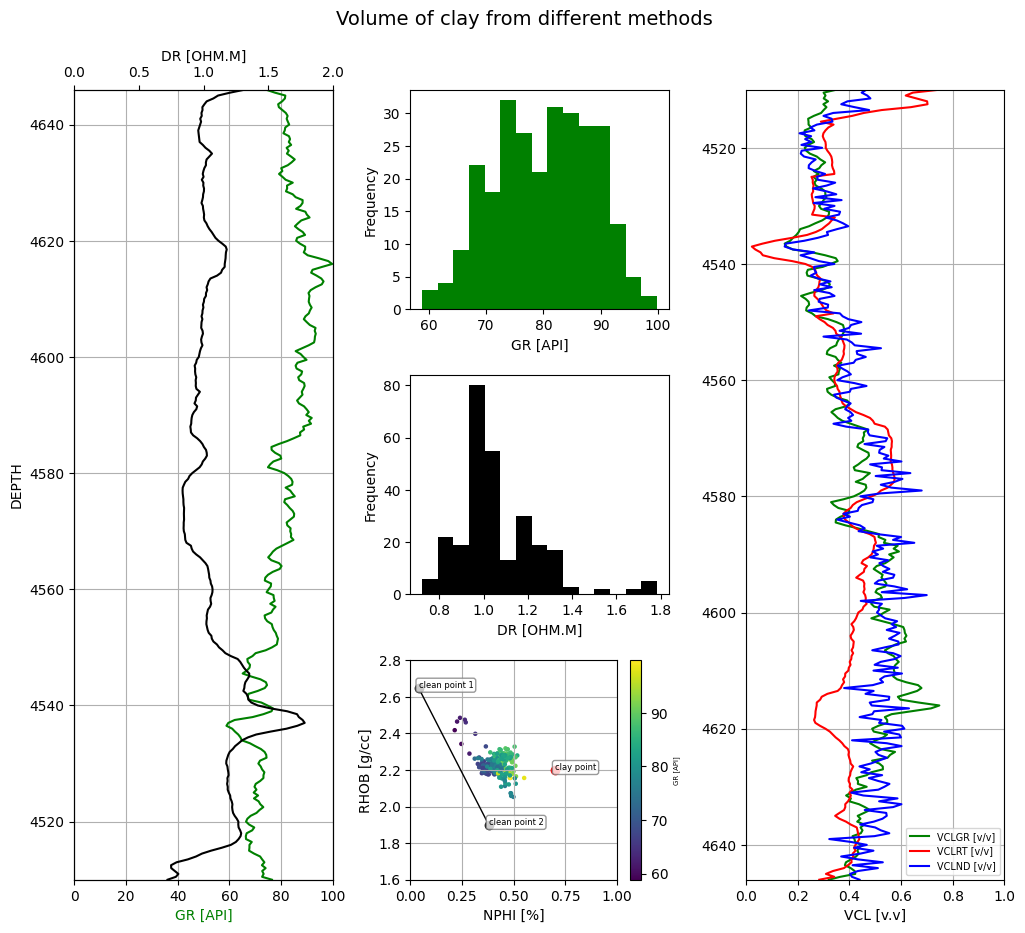

In [27]:
vcl_plot(
    calculation_data,
    depth_start,
    depth_end,
    traject1={
        "data": ["GR", "DR"],
        "intervals": [(0, 100), (0, 2)],
        "scales": ["linear", "linear"],
        "labels": ["GR [API]", "DR [OHM.M]"],
        "colors": ["green", "black"],
    },
    traject2={
        "data": ["GR", "DR"],
        "scales": ["linear", "linear"],
        "labels": ["GR [API]", "DR [OHM.M]"],
        "colors": ["green", "black"],
    },
    traject3={
        "data": ["VCLGR", "VCLRT", "VCLND"],
        "labels": ["VCLGR [v/v]", "VCLRT [v/v]", "VCLND [v/v]"],
        "colors": ["green", "red", "blue"],
    },
    nphi_axis=[0, 1],
    rhob_axis=[1.6, 2.8],
)

### **6.7 Choose the Best VCL**

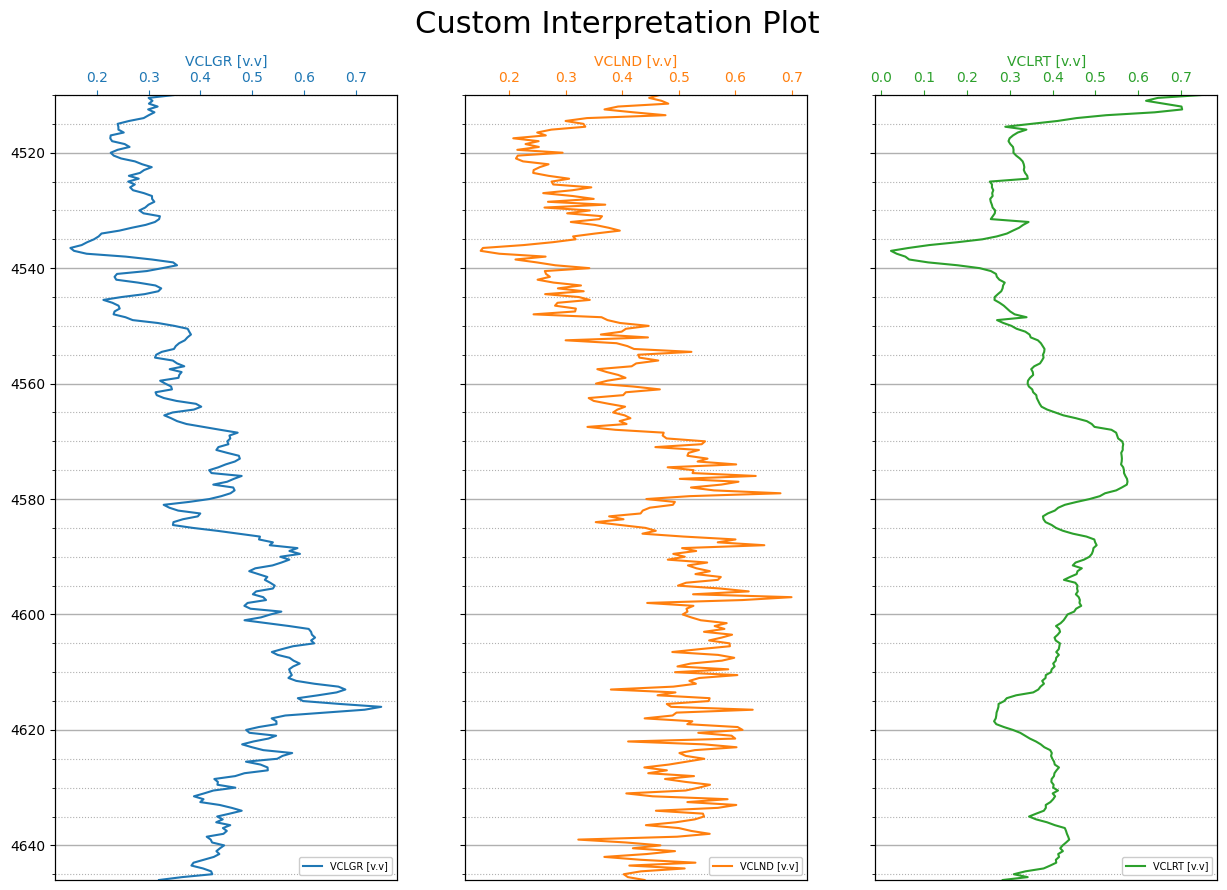

In [28]:
custom_interpretation_plot(
    calculation_data,
    depth_start,
    depth_end,
    custom_data=["VCLGR", "VCLND", "VCLRT"],
    units=["v.v", "v.v", "v.v"],
)

To make the understanding easier, we will treat VCLGR as equivalent to VCL.
Alternatively, from 2 sub plot above, we can view vcl as the smallest value derived from various techniques, where VCL equals the minimum among VCLGR, VCLSP, and VCLND.

In [29]:
calculation_data["VCL"] = calculation_data["VCLGR"]

## **7. POROSITY CALCULATION**
There are three types of logs that can be used to estimate porosity: sonic, density, and neutron logs. Porosity can be determined using either individual or paired combinations of these logs. The possible combinations include neutron-density, neutron-sonic, and sonic-density.<br>
**Basic porosity formulas are:**
- Sonic:
    - Wyllie (Time Average)
    - Raymer-Hunt-Gardner
- Density
- Neutronic<br>

### **7.1. Shale Porosity Equation**
**Shale porosity with sonic Log:** <br>
$\phi_{shale[sonic]} = \frac{\Delta T_{sh}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$
**Shale porosity with density log:** <br>
$\phi_{shale[density]} = \frac{\rho _{sh}-\rho _{ma}}{\rho _{fl}-\rho _{ma}}$
*Formula Explanation:*
- $\phi_{shale[sonic]}$: Shale porosity with sonic Log.
- $\phi_{shale[density]}$: Shale porosity with density log.
- $\Delta T_{sh}$: Sonic transit time in shale.
- $\Delta T_{ma}$: Sonic transit time in matrix.
- $\Delta T_{fl}$: Sonic transit time in fluid.
- $\rho _{sh}$: Density in shale.
- $\rho _{ma}$: Density in matrix.
- $\rho _{fl}$: Density in fluid.

In [30]:
# Willie-TimeAverage
def phis_shale(dt_sh, dt_ma, dt_fl):
    phis_shale = (dt_sh - dt_ma) / (dt_fl - dt_ma)
    return phis_shale

In [31]:
def phid_shale(den_sh, den_ma, den_fl):
    phid_shale = (den_sh - den_ma) / (den_fl - den_ma)
    return phid_shale

### **7.2. Wyllie Time-Average Equation**
**Porosity in the part under review:** <br>
$\phi_{[sonic][Wyllie]} = \frac{1}{cp}\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{fl}-\Delta T_{ma}}$
#
**Effective porosity:** <br>
$\phi_{corr[sonic][Wyllie]} = {\phi_{[sonic][Wyllie]}}-{v_{cl}\times\phi_{shale[sonic]}}$
#
*Formula Explanation:*
- $\phi_{[sonic][Wyllie]}$: Porosity in the part under review using Wyllie Time-Average equation.
- $\phi_{corr[sonic][Wyllie]}$: Effective porosity considering volume of clay.

In [32]:
def phis_w(dt_log, dt_ma, dt_fl, cp):
    phis_w = (1 / cp) * (dt_log - dt_ma) / (dt_fl - dt_ma)
    return phis_w

In [33]:
def phis_w_sh_corr(dt_log, dt_ma, dt_fl, cp, dt_sh, vcl):
    phis_w_sh_corr = phis_w(dt_log, dt_ma, dt_fl, cp) - vcl * phis_shale(
        dt_sh, dt_ma, dt_fl
    )
    return phis_w_sh_corr

### **7.3. Raymer Hunt Gardner Equation**
**Porosity in the part under review:** <br>
$\phi_{[sonic][Raymer]} = \alpha\times \frac{\Delta T_{log}-\Delta T_{ma}}{\Delta T_{log}}$
#
**Effective porosity:** <br>
$\phi_{corr[sonic][raymer]} = {\phi_{[sonic][raymer]}}-{v_{cl}\times\phi_{shale[sonic]}}$
#
*Formula Explanation:*
- $\phi_{[sonic][Raymer]}$: Porosity in the part under review using Raymer Hunt Gardner equation.
- $\phi_{corr[sonic][raymer]}$: Effective porosity considering volume of clay.

In [34]:
# Raymer-Hunt-Gardner (the alpha(5/8) ranges from 0.625-0.70, 0.67-most, 0.60-gas reservoirs)
def phis_rhg(dt_log, dt_ma, alpha):
    phis_rhg = (alpha) * (dt_log - dt_ma) / (dt_log)
    return phis_rhg

In [35]:
def phis_rhg_sh_corr(dt_log, dt_ma, dt_sh, vcl, alpha, dt_fl):
    phis_rhg_sh_corr = phis_rhg(dt_log, dt_ma, alpha) - vcl * phis_shale(
        dt_sh, dt_ma, dt_fl
    )
    return phis_rhg_sh_corr

### **7.4. Density Equation**
**Porosity in the part under review:** <br>
$\phi_{[density]} = \frac{\rho_{log}-\rho_{ma}}{\rho_{fl}-\rho_{ma}}$
#
**Effective porosity:** <br>
$\phi_{corr[density]} = {\phi_{[density]}}-{v_{cl}\times\phi_{shale[density]}}$
#
*Formula Explanation:*
- $\phi_{[density]}$: Porosity in the part under review using density log.
- $\phi_{corr[density]}$: Effective porosity considering volume of clay.

In [36]:
# Density
def phid(rho_log, rho_m, rho_f, new=True):
    if new:
        phid = (rho_m - rho_log) / (rho_m - rho_f)
    else:
        phid = (rho_log - rho_m) / (rho_f - rho_m)
    return phid


def phi_simandoux(vsh, phid):
    base_eq = (vsh**2) + (phid**2)
    phi = np.sqrt(base_eq / 2)

    return phi

In [37]:
def phid_sh_corr(den_log, den_ma, den_fl, den_sh, vcl):
    phid_sh_corr = phid(den_log, den_ma, den_fl) - vcl * phid_shale(
        den_sh, den_ma, den_fl
    )
    return phid_sh_corr

### **7.5. Neutron Equation**
**Effective porosity:** <br>
$\phi_{[corr][neutron]} = \frac{nphi_{log}-vcl\times nphi_{shale}}{100}$
#
*Formula Explanation:*
- $\phi_{[corr][neutron]}$: Effective porosity using neutron log.
- $nphi_{log}$: Neutron porosity log value.
- $vcl$: Volume of clay.

In [38]:
# Neutron
def phin_sh_corr(neut, neut_sh, vcl):
    phin_sh_corr = (neut - vcl * neut_sh) / 100
    return phin_sh_corr

### **7.6. Neutron-Density Equation**
$\phi_{[neutronxdensity]} = \frac{\phi_{nshc} + \phi_{dshc}}{2}$
#
$\phi_{[corr][neutronxdensity]} = \sqrt{\frac{\phi_{n}^2 + \phi_{d}^2}{2}}$
#
*Formula Explanation:*
- $\phi_{[neutronxdensity]}$: Porosity using neutron-density combination.
- $\phi_{[corr][neutronxdensity]}$: Effective porosity considering neutron-density combination.
- $\phi_{nshc}$, $\phi_{dshc}$: Neutron and density porosities in shale and clean formations.
- $\phi_{n}$, $\phi_{d}$: Neutron and density porosities.

In [39]:
# Neutron-Density
def phixnd(phinshc, phidshc):
    phixnd = (phinshc + phidshc) / 2
    return phixnd


def phixnd_gas_corr(phin, phid, phin_sh, phid_sh):
    phixnd_gas_corr = ((phin**2 + phid**2) / 2) ** (
        0.5
    )  # for gas intervals (nphi<dphi = crossover)
    return phixnd_gas_corr

### **7.7. Resistivity Equation**
**7.7.1. Volume of Clay using Resistivity log:** <br>
$V_{rt} = \frac{rt_{clay}}{rt_{log}} \times \frac{rt_{clean} - rt_{log}}{rt_{clean} - rt_{clay}}$
#
- **Formula Explanation:**
  - $V_{rt}$: Volume of Clay using Resistivity log.
  - $rt_{clay}$: Resistivity in clay-rich formations.
  - $rt_{log}$: Resistivity log value.
  - $rt_{clean}$: Resistivity in clean formations.
  - $st_{clay}$: Saturation in clay-rich formations.

### **7.7. Define the Parameter for Porosity Calculation**

In [40]:
# Matrix, fluid and appropiate shales values must be declared in the next variables:
dt_ma, dt_fl, dt_sh, cp, alpha = 55.5, 188.0, 90.0, 1, 5 / 8
den_ma = 2.65
den_fl = 0.1
den_sh = den_clay

phis_sh = phis_shale(dt_sh, dt_ma, dt_fl)
phid_sh = phis_shale(den_sh, den_ma, den_fl)
phin_sh = 45

### **7.8. All Porosity Calculation**

In [41]:
# # 1. Poro calc with DT
# calculation_data["PHISw"] = phis_w(calculation_data.DT, dt_ma, dt_fl, cp)
# calculation_data["PHISwshc"] = phis_w_sh_corr(
#     calculation_data.DT, dt_ma, dt_fl, cp, dt_sh, logs.VCL
# ).clip(-1, 1)

# logs["PHISrhg"] = phis_rhg(logs.DT, dt_ma, alpha)
# logs["PHISrhgshc"] = phis_rhg_sh_corr(
#     logs.DT, dt_ma, dt_sh, logs.VCL, alpha, dt_fl
# ).clip(0, 1)

# # 2. Poro calc with RHOB
calculation_data["PHID"] = phid(data.RHOB, den_ma, den_fl, new=True)
calculation_data["PHIDshc"] = phid_sh_corr(
    data.RHOB, den_ma, den_fl, den_sh, calculation_data.VCL
).clip(0, 1)

# # 3. Poro calc for Simandoux using VSH param
calculation_data["PHI_SIMANDOUX"] = phi_simandoux(data.VSH, calculation_data.PHID).clip(
    0, 1
)

# # 4. Poro calc with NPHIN (Dual-method)
calculation_data["PHIN"] = (data.NPHI_corr / 100).clip(0, 1)
calculation_data["PHINshc"] = phin_sh_corr(
    data.NPHI_corr, phin_sh, calculation_data.VCL
).clip(0, 1)

calculation_data["PHIxND"] = phixnd(
    calculation_data.PHINshc, calculation_data.PHIDshc
).clip(0, 1)

### **7.9 Choose the Best PHIE**

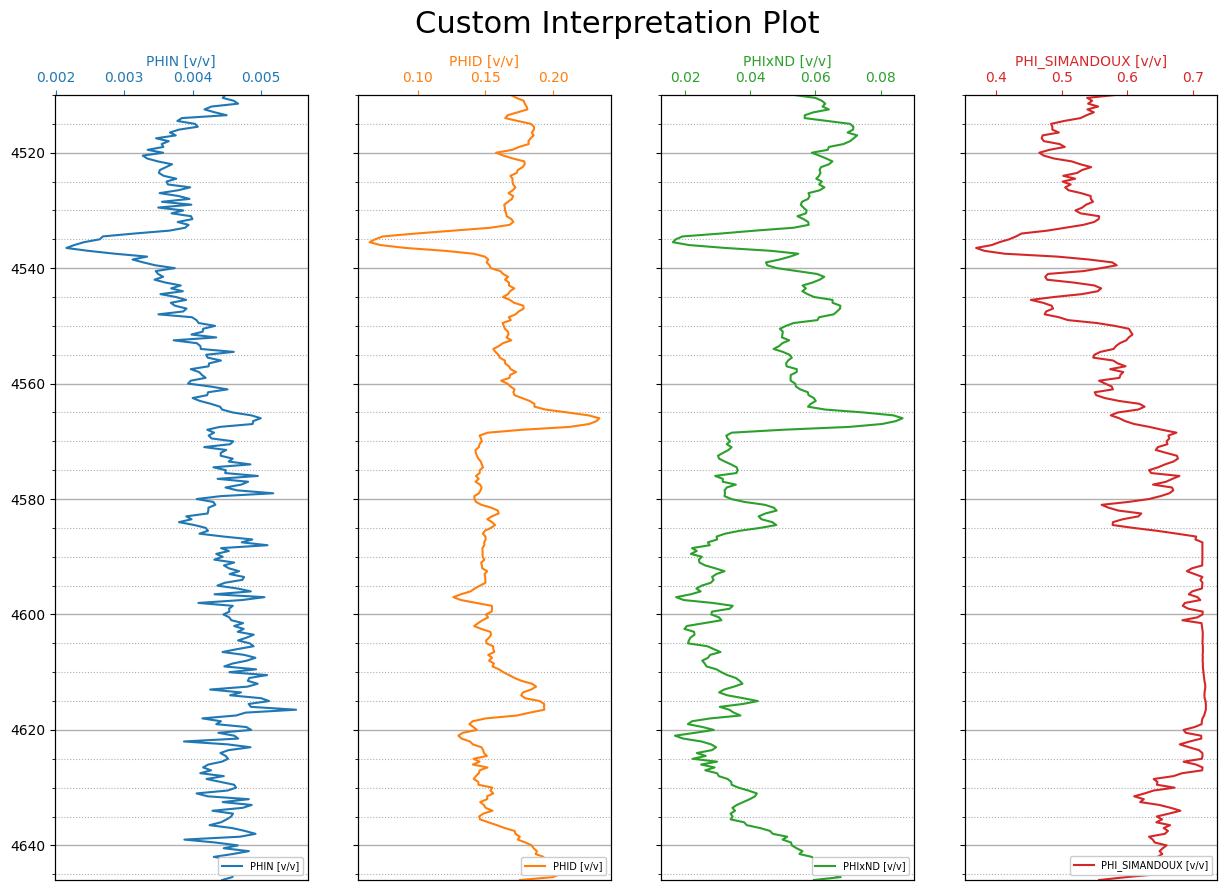

In [42]:
# Example usage:
custom_interpretation_plot(
    calculation_data,
    depth_start,
    depth_end,
    custom_data=["PHIN", "PHID", "PHIxND", "PHI_SIMANDOUX"],
    units=["v/v", "v/v", "v/v", "v/v"],
)

In [43]:
# Choosing the best porosity calc for SW (waxman, indonesia, archie) calc later on this code
calculation_data["PHIE"] = calculation_data["PHIxND"]

## **8. WATER SATURATION CALCULATION**
Before calculating the water saturation will need a value for the Rw (Resistivity of water)<br>
**Resistivity of water:**
It can be determined from:
- Ater catalogs <br>
- DST test water analysis <br>
- Rw from SP (needs information about Rmud and ... ) <br>
- Rwa Method (Rw from a 100% water zone) <br>

### **8.1. Archie Water Sturation Equation**
Suppose we lack any prior knowledge of Rwater. In such cases, following the best approach involves utilizing a PICKETT graph. This graph takes on a logarithmic form derived from Archie's equation:
#
$Sw^{n} = \frac{a \times R_w}{R_t \times \phi^m}$

In [44]:
def sw_archie(Rw, Rt, Poro, a, m, n):
    F = a / (Poro**m)
    Sw_archie = (F * Rw / Rt) ** (1 / n)
    return Sw_archie

The equation can be transformed into a logarithmic expression and visualized on a log plot of RT against PHI:
#
$\log \phi = -\frac{1}{m} \log(R_t) - n \log(S_w) + \log(a\times R_w)$

In [45]:
def pickett_plot(data, depth_start, depth_end, vcl_limit, a, rwa, m, n, z):
    plt.figure(figsize=(7, 6))
    plt.title("Pickett Plot" + "%" + " and Rw = " + str(rwa) + " ohm.m")
    c = data[z][
        (data.DEPT >= depth_start) & (data.DEPT <= depth_end) & (data.VCL < vcl_limit)
    ]
    plt.scatter(
        data.DR[
            (data.DEPT >= depth_start)
            & (data.DEPT <= depth_end)
            & (data.VCL < vcl_limit)
        ],
        data.PHIE[
            (data.DEPT >= depth_start)
            & (data.DEPT <= depth_end)
            & (data.VCL < vcl_limit)
        ],
        c=c,
        s=20,
        cmap="plasma",
    )
    cbar = plt.colorbar()
    cbar.set_label(f"{z}")
    plt.xlim(0.1, 1000)
    plt.ylim(0.01, 1)
    plt.ylabel("PHIE [v/v]")
    plt.xlabel("DR [m.ohm]")
    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")

    # calculate the saturation lines
    sw_plot = (1.0, 0.8, 0.6, 0.4, 0.2)
    phie_plot = (0.01, 1)
    rt_plot = np.zeros((len(sw_plot), len(phie_plot)))

    for i in range(0, len(sw_plot)):
        for j in range(0, len(phie_plot)):
            rt_result = (a * rwa) / (sw_plot[i] ** n) / (phie_plot[j] ** m)
            rt_plot[i, j] = rt_result
    for i in range(0, len(sw_plot)):
        plt.plot(rt_plot[i], phie_plot, label="SW " + str(int(sw_plot[i] * 100)) + "%")
        plt.legend(loc="best")

    plt.grid(True, which="both", ls="-", color="gray")

#### **8.1.1. Define the Paramater for Archie Water Saturation Calculation**

Firstly, it's important to establish the values for the variables: a, m, and n. To initiate this process, you might consider beginning with the values (a=1, m=2, n=2), which tend to yield favorable results across various rock types. In cases where the rock matrix contains a mixture of shale, it might be advisable to reduce the value of m to 1.8.
- a, turtuosity factor
- m, cementation factor
- n, saturation exponent
- rwa, water resistivity
- vcl_limit, volume of clay upper limit for selction of data for graph

In [46]:
a = 0.9
m = 1
n = 1.8

rw_input = 0.06

#### **8.1.2. Choose the Water Resistivity**

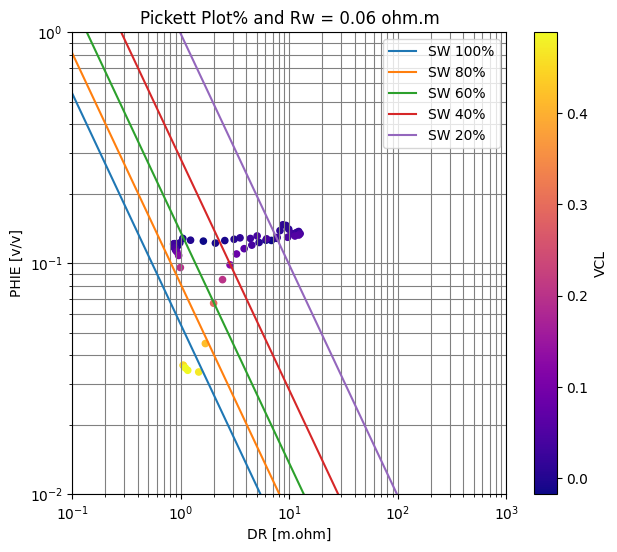

In [47]:
pickett_plot(
    calculation_data,
    depth_start=4320,
    depth_end=4350,
    vcl_limit=0.5,
    a=a,
    rwa=rw_input,
    m=m,
    n=n,
    z="VCL",
)

The outcomes obtained from the Pickett plot indicate the presence of distinct intervals within two zones, warranting separate interpretation and analysis. To initiate the process, we will select an appropriate value for Rwa and utilize the Archie equation to compute the Sw curve.
Next, proceed to select the water resistivity, denoted as rwa. We will create a Pickett chart by plotting Resistivity against Porosity. To curate the data for this plot, focus exclusively on the reservoir formations while excluding the shaly intervals. This can be accomplished by adjusting the vcl_limit variable, which represents the volume of clay.

### **8.2 Waxman-Smits Water Sturation Equation**
$B_{max} = 51.31\times log(T+460)-317.2$ <br>
$B = (1 - \frac{0.83}{exp(0.5/Rw)}) \times B_{max}$ <br>
$F = \frac{a}{\phi^m}$ <br>
$Swi = (F\times\frac{Rw}{Rt})^{\frac{1}{n}}$ <br>
**Iterate** <br>
$Sw = (\frac{F}{\frac{Rt}{(1 / Rw + (b * Qv / Swi))}}) ^ {\frac{1}{n}}$ <br>
$Sw = (F / Rt / (1 / Rw + (b * Qv / Swi))) ^ {\frac{1}{n}}$

In [54]:
def sw_waxman(Rw, Qv, a, m, n, Temp, Rt, Phi):
    try:
        # Input validation
        if Rw == 0 or Rt == 0 or Phi == 0 or n == 0:
            return np.nan

        Sw, Swi = 0.0, 0.0

        # Calculate Bmax and b
        Bmax = 51.31 * math.log(Temp + 460) - 317.2
        b = (1 - 0.83 / math.exp(0.5 / Rw)) * Bmax
        F = a / (Phi**m)

        # Initial Swi calculation
        Swi = (F * Rw / Rt) ** (1 / n)

        # Protect against Swi being zero in the loop
        while abs(Sw - Swi) > 0.01 and Swi != 0:
            denominator = 1 / Rw + (b * Qv / Swi)
            if denominator == 0:
                return np.nan

            Sw = (F / Rt / denominator) ** (1 / n)
            Swi = Sw

        return Sw

    except:
        return np.nan

#### **8.2.1. Define the Thermal Gradient for Waxman-Smits Water Saturation Calculation**

In [55]:
# Geothermal Gradient
mid_perf = 13950  # TVD
BHT_mid_perf = 192  # Fahrenheit
T_surf = 60  # Fahrenheit
T_gradient = (BHT_mid_perf - T_surf) / (mid_perf)  # Fahrenheit/ft

#### **8.2.2. By using the same parameters as Archie, calculate the Wwter saturation using Waxman-Smits**

In [56]:
# Create new column 'CEC' and 'T' for SWwaxman Calc
calculation_data["CEC"] = (
    -47.619 * calculation_data["VCL"] ** 2.0 + 61.429 * calculation_data["VCL"]
)
calculation_data["T"] = T_surf + T_gradient * data["DEPT"]

### **8.3 Poupon-Laveaux (Indonesia) Water Sturation Equation**

In [57]:
def sw_indonesia(Rw, Rt, Poro, a, m, n, vcl, rsh):
    """
    Vectorized implementation of the Indonesia Sw calculation

    Parameters:
    -----------
    Rw, Rt, Poro, a, m, n, vcl, rsh : numpy arrays or pandas Series
        Input parameters for the Indonesia equation

    Returns:
    --------
    numpy array
        Water saturation values
    """
    # Create a mask for invalid inputs
    invalid_mask = (Rt == 0) | (rsh == 0) | (a == 0) | (n == 0)

    # Calculate terms using numpy operations
    vcl_term = np.power(vcl, 1 - (0.5 * vcl))
    poro_term = np.power(Poro, m) / (a * Rw)

    # Calculate denominator
    denominator = (vcl_term / np.sqrt(rsh)) + np.sqrt(poro_term)

    # Update invalid mask for zero denominators
    invalid_mask = invalid_mask | (denominator == 0)

    # Final calculation
    Sw_indonesia = np.power((1 / Rt) / denominator, 2 / n)

    # Apply range validation (0 to 1)
    invalid_mask = invalid_mask | (Sw_indonesia < 0) | (Sw_indonesia > 1)

    # Create result array with nan values for invalid results
    result = Sw_indonesia.copy()
    result[invalid_mask] = np.nan

    return result

### **8.4 Simandoux SW**

In [58]:
def sw_simandoux(Rw, Rt, Vsh, Poro, a, m, n, Rsh):
    F = a / (Poro**m)
    X = Vsh / Rsh
    term = X**2 + (4 / a) * F * Rw / Rt
    Sw_modsim = (F * (Rw / 2) * (np.sqrt(term) - X)) ** (2 / n)

    return Sw_modsim

In [59]:
# Start SW calculation routine here:

calculation_data["SWarchie"] = sw_archie(
    rw_input, data.DR, calculation_data.PHIE, a, m, n
).clip(0, 1)
calculation_data["SWsimandoux"] = sw_simandoux(
    rw_input, data.DR, data.VSH, calculation_data.PHI_SIMANDOUX, a, m, n, data.DR
).clip(0, 1)

calculation_data["SWindonesia"] = sw_indonesia(
    rw_input, data.DR, calculation_data.PHIE, a, m, n, calculation_data.VCL, rsh=100
)

calculation_data["SWwaxman"] = calculation_data.apply(
    lambda row: sw_waxman(
        rw_input, row["CEC"], a, m, n, row["T"], row["DR"], row["PHIE"]
    ),
    axis=1,
).clip(0, 1)

/home/wksnr/.pyenv/versions/wellLog-corr/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/home/wksnr/.pyenv/versions/wellLog-corr/lib/python3.10/site-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


**Calculate the BVW (bulk volume of water):**

In [60]:
calculation_data["BVW"] = calculation_data["SWarchie"] * calculation_data["PHIE"]
calculation_data["matrix"] = 1 - calculation_data["VCL"] - calculation_data["PHIE"]

In [61]:
calculation_data[["SWindonesia", "SWarchie", "SWwaxman", "SWsimandoux"]]

,SWindonesia,SWarchie,SWwaxman,SWsimandoux
0,NaN,NaN,0.0+0.0j,NaN
1,NaN,NaN,0.0+0.0j,NaN
2,NaN,NaN,0.0+0.0j,NaN
3,NaN,NaN,0.0+0.0j,NaN
4,NaN,NaN,0.0+0.0j,NaN
...,...,...,...,...
10128,NaN,NaN,0.0+0.0j,NaN
10129,NaN,NaN,0.0+0.0j,NaN
10130,NaN,NaN,0.0+0.0j,NaN
10131,NaN,NaN,0.0+0.0j,NaN


### **8.5 Choose the Best SW**

/home/wksnr/.pyenv/versions/wellLog-corr/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/wksnr/.pyenv/versions/wellLog-corr/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


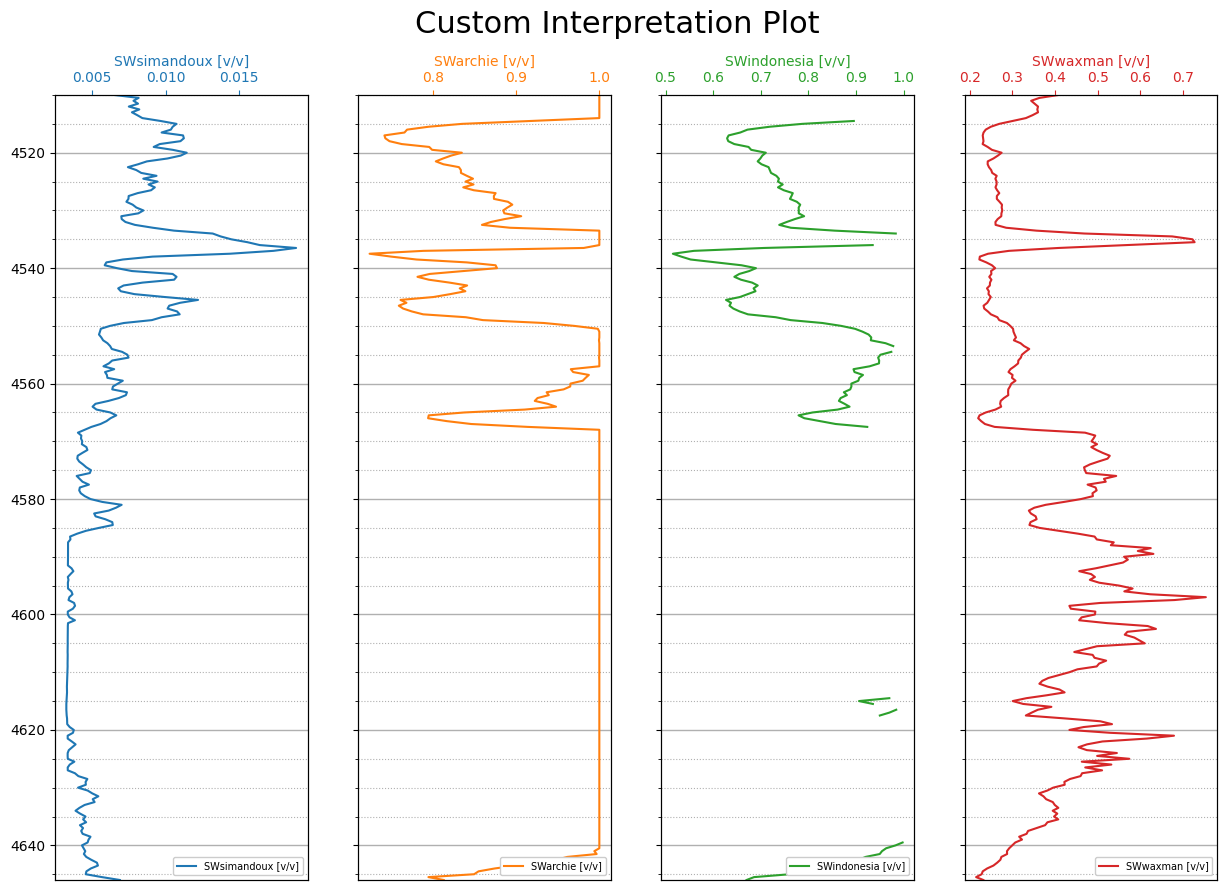

In [62]:
custom_interpretation_plot(
    calculation_data,
    depth_start,
    depth_end,
    custom_data=["SWsimandoux", "SWarchie", "SWindonesia", "SWwaxman"],
    units=["v/v", "v/v", "v/v", "v/v"],
)

## **9. PERMEABILITY CALCULATION**

In [63]:
def perm_timur(phie, sw):
    perm = ((93 * (phie**2.2)) / sw) ** 2
    return perm

In [64]:
calculation_data["PERMtimur"] = calculation_data.apply(
    lambda row: perm_timur(row["PHIE"], row["SWarchie"]), axis=1
)

## **10. DISPLAY THE INTERPRETATION PLOT**
Create a plot template and add the results of volume of clay, saturation, permeability, and porosity.

In [65]:
def interpretation_plot(
    data,
    depth_start,
    depth_end,
    traject1: dict,
    traject2: dict,
    traject3: dict,
    traject4: dict,
    traject5: dict,
    traject6: dict,
    traject7: dict,
    fill=True,
):
    # filter the data
    data = data[(data.DEPT >= depth_start) & (data.DEPT <= depth_end)]

    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12), sharey=True)
    fig.suptitle("Interpretation Plot", fontsize=22)
    fig.subplots_adjust(top=0.85, wspace=0.4)

    # General setting for all axis
    for axes in ax:
        axes.set_ylim(depth_start, depth_end)
        axes.invert_yaxis()
        axes.yaxis.grid(True, which="minor", linestyle=":")
        axes.yaxis.grid(True, which="major", linestyle="-", linewidth="1")
        axes.yaxis.set_major_locator(ticker.AutoLocator())
        axes.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        axes.get_xaxis().set_visible(False)

    # 1st track: GR, SP, CALI track
    add_trajectory(ax[0], data, traject1)

    # 2nd track
    add_trajectory(ax[1], data, traject2)

    # 3rd track
    add_trajectory(ax[2], data, traject3)

    # 4th track
    add_trajectory(ax[3], data, traject4)

    # 5th track
    add_trajectory(ax[4], data, traject5)

    # 6th track
    add_trajectory(ax[5], data, traject6)

    # 7th track
    add_trajectory(ax[6], data, traject7)

    if fill:
        # BVW porosity fill plot
        ax[5].fill_betweenx(data.DEPT, 0, data.BVW, color="lightblue")
        ax[5].fill_betweenx(data.DEPT, data.PHIE, data.BVW, color="red")

        # Porosity vcl fill options
        ax[6].fill_betweenx(
            data.DEPT, 0, data.PHIE, color="lightgray", label="porosity"
        )
        ax[6].fill_betweenx(
            data.DEPT, data.PHIE, 1 - data.VCL, color="orange", label="matrix"
        )
        ax[6].fill_betweenx(
            data.DEPT, 1 - data.VCL, 1, color="lightgreen", label="Vclay"
        )
        ax[6].legend(loc="lower left")

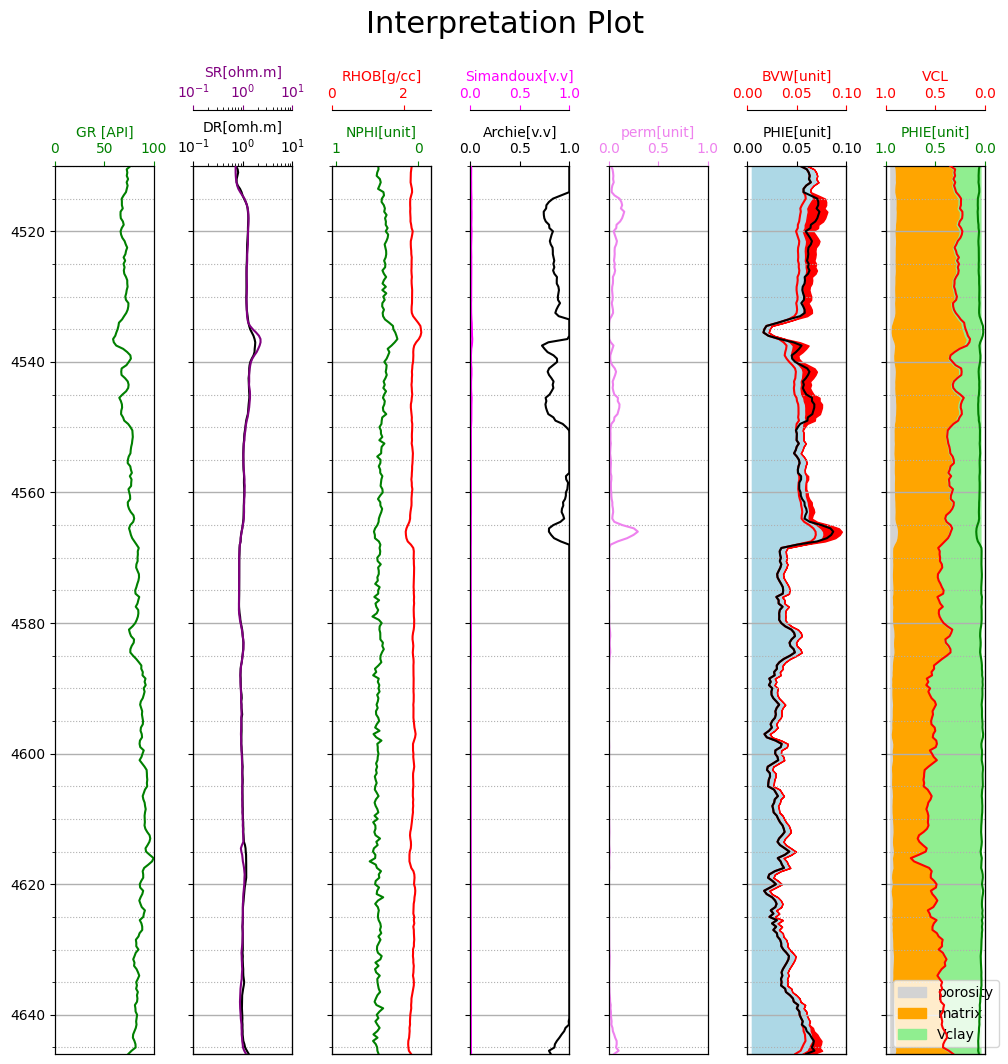

In [66]:
interpretation_plot(
    calculation_data,
    depth_start,
    depth_end,
    traject1={
        "data": ["GR"],
        "intervals": [(0, 100)],
        "scales": ["linear"],
        "labels": ["GR [API]"],
        "positions": [0],
        "colors": ["green"],
    },
    traject2={
        "data": ["DR", "SR"],
        "intervals": [(0.1, 10), (0.1, 10)],
        "scales": ["log", "log"],
        "labels": ["DR[omh.m]", "SR[ohm.m]"],
        "positions": [0, 40],
        "colors": ["black", "purple"],
    },
    traject3={
        "data": ["RHOB", "NPHI"],
        "intervals": [(0, 2.75), (1.05, -0.15)],
        "scales": ["linear", "linear"],
        "labels": ["RHOB[g/cc]", "NPHI[unit]"],
        "positions": [40, 0],
        "colors": ["red", "green"],
    },
    traject4={
        "data": ["SWarchie", "SWsimandoux"],
        "intervals": [(0, 1), (0, 1)],
        "scales": ["linear", "linear"],
        "labels": ["Archie[v.v]", "Simandoux[v.v]"],
        "positions": [0, 40],
        "colors": ["black", "magenta"],
    },
    traject5={
        "data": ["PERMtimur"],
        "intervals": [(0, 1)],
        "scales": ["linear"],
        "labels": ["perm[unit]"],
        "positions": [0],
        "colors": ["violet"],
    },
    traject6={
        "data": ["BVW", "PHIE"],
        "intervals": [(0, 0.1), (0, 0.1)],
        "scales": ["linear", "linear"],
        "labels": ["BVW[unit]", "PHIE[unit]"],
        "positions": [40, 0],
        "colors": ["red", "black"],
    },
    traject7={
        "data": ["PHIE", "VCL"],
        "intervals": [(1, 0), (1, 0)],
        "scales": ["linear", "linear"],
        "labels": ["PHIE[unit]", "VCL"],
        "positions": [0, 40],
        "colors": ["green", "red"],
    },
    fill=True,
)

In [67]:
# Specify the file path where you want to save the Excel file
file_path = "../results/output1.xlsx"

# Export the DataFrame to an Excel file
calculation_data.to_excel(
    file_path, index=False
)  # Set index=False to exclude the index column

print(f"DataFrame has been exported to {file_path}")

DataFrame has been exported to ../results/output1.xlsx
